# Image Processing

## Initial Plotly 2D Gray-Scale Histogram

In [13]:
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

def heatmap(directory, csv_name, x_branch, y_branch, title, x_label, y_label, width, height, size, bins, save_as):

    csv_file = os.path.join(directory, csv_name)
    df = pd.read_csv(csv_file)

    x_data = df[x_branch]
    y_data = df[y_branch]

    fig = go.Figure(go.Histogram2d(
                    x = x_data, 
                    y = y_data,
                    autobinx = False,
                    xbins = dict(start = -size, end = size, size = bins),
                    autobiny = False,
                    ybins = dict(start = -size, end = size, size = bins),
                    colorscale=[[0, 'white'], [1, 'black']],  # Grayscale from black to white
                    colorbar = dict(title = "Density", tickfont = dict(family = 'Merriweather', size = 16, color = 'Black'))))
    
    font_family = 'Merriweather'
    font_small  = 16
    font_medium = 20
    font_large  = 18
    
    fig.update_layout(
                    title = dict(text = title, font = dict(family = font_family, size = font_large, color = "Black"), 
                                 x = 0.51, y = 0.93, yanchor = 'middle', xanchor = 'center'),
                    xaxis_title = dict(text = x_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    yaxis_title = dict(text = y_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    xaxis = dict(tickfont = dict(family = font_family, size = font_small, color = "Black"), title_standoff = 25),
                    yaxis = dict(tickfont = dict(family = font_family, size = font_small, color = "Black"), title_standoff = 10),
                    width  = width,
                    height = height,
                    margin = dict(l = 105, r = 90, t = 90, b = 90),
                    )
    
    # pio.write_image(fig, save_as, width = width, height = height, scale = 5)
    fig.show()

In [ ]:
directory = 'build/root/'
csv_name = 'pruebita.csv'

x_branch = "X_axis"
y_branch = 'Y_axis'

title = r"$ \large{ \text{Osteoporosis.}} \ \normalsize{ \text{D to Target} =50cm, \ \text{D to Detector} =15cm, \ \theta = 0°} $"
x_label = r"$ \large{ \text{X Axis} \ (mm)} $"
y_label = r"$ \large{ \text{Y Axis} \ (mm)} $"

width  = 800
height = 800

size = 100
bins = 1

save_as = 'Results/jp1.jpg'

heatmap(directory, csv_name, x_branch, y_branch, title, x_label, y_label, width, height, size, bins, save_as)

## Numpy Heatmap Matrix, Normalize

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def heatmap_array(directory, csv_name, x_branch, y_branch, size, num):
    
    csv_file = os.path.join(directory, csv_name)
    df = pd.read_csv(csv_file)

    x_data = df[x_branch]
    y_data = df[y_branch]

    set_bins = np.arange(-size, size + 1, size/num)
    heatmap, x_edges, y_edges = np.histogram2d(x_data, y_data, bins = [set_bins, set_bins])
    heatmap = heatmap.T
    # print(heatmap.shape)

    row = len(set_bins) // 2
    normal_map = 1 - heatmap / np.max(heatmap)
    plt.plot(normal_map[:][row])
    maxi = np.max(normal_map[:5])
    maxi = maxi * 1.2
    print('altura de ruido:', round(maxi, 4))
    normal_map[normal_map < maxi] = 0

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(normal_map, cmap='gray', extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    plt.subplot(1, 2, 2)
    plt.plot(normal_map[:][row])
    # plt.savefig('Results/circ1_2.jpg', dpi = 300)

    return normal_map, x_edges, y_edges

    # optional: save array as csv
    # np.savetxt("Results/array2.csv", htmp_array, delimiter=",", fmt="%f")
    # print(htmp_array.shape)

altura de ruido: 0.2927


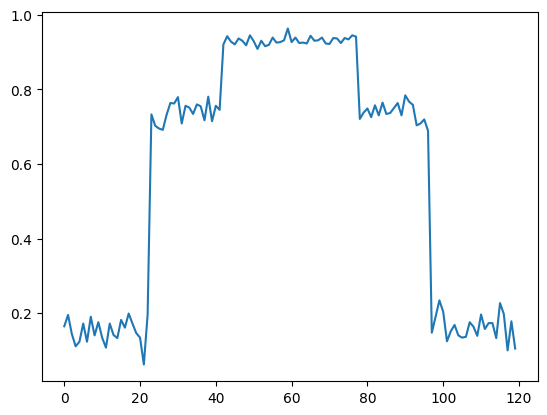

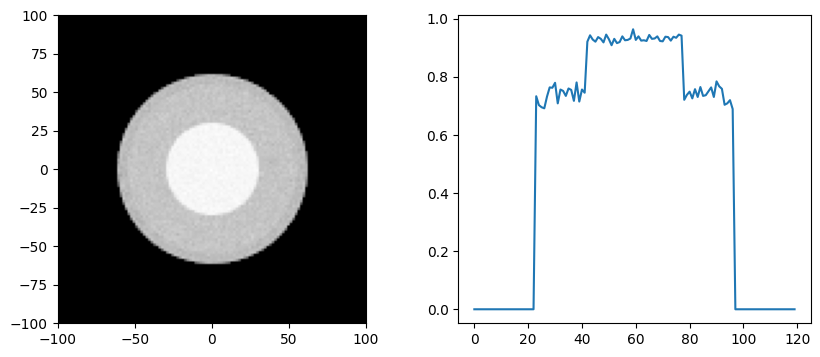

In [3]:
directory = 'build/root/'
csv_name = 'jp1.csv'

x_branch = "X_axis"
y_branch = 'Y_axis'

size = 100
bins = 60

htmp_array, xlim, ylim = heatmap_array(directory, csv_name, x_branch, y_branch, size, bins)

## Eliminate Noise by Fourier Transform

In [22]:
import numpy as np
from scipy.fft import fft2, fftshift, ifft2
import matplotlib.pyplot as plt
from scipy import signal

def Denoise(htmp_array, hann, alpha):

    image = htmp_array

    fft_image = fft2(image)
    fft_image = fftshift(fft_image)

    rows, cols = image.shape

    hann = False
    if hann == True:
    
        l = rows * alpha
        a = np.hanning(l)
        b = np.hanning(l)

        padding_size = rows - len(a)
        left_padding = padding_size // 2
        right_padding = padding_size - left_padding
        a = np.pad(a, (left_padding, right_padding), mode='constant')

        padding_size = cols - len(b)
        left_padding = padding_size // 2
        right_padding = padding_size - left_padding
        b = np.pad(b, (left_padding, right_padding), mode='constant')

        window = np.outer(a, b)

    else:

        a = signal.windows.tukey(rows, alpha)
        b = signal.windows.tukey(rows, alpha)
        window = np.outer(a, b)

    plt.figure(figsize=(10, 2))
    plt.subplot(1, 3, 2)
    plt.plot(a)

    fft_image_2 = fft_image * (window)

    plt.subplot(1, 3, 3)
    plt.plot(np.abs((fft_image_2[:][rows//2])))

    fft_image = fftshift(fft_image_2)
    fft_image = (ifft2(fft_image))
    fft_image = (np.abs(fft_image))

    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Filtered Image')
    plt.imshow(fft_image, cmap='gray')
    plt.savefig('Results/four1.jpg', dpi = 300)
    plt.show()

    print(fft_image.shape)
    plt.plot(fft_image[:][60])

    return fft_image

In [ ]:
hann = False
alpha = .1
fft_image = Denoise(htmp_array, hann, alpha)

## Calculate CNR

In [4]:
# start is the start row number and end is the end row number
# Background is every value in which window average < row average * 1.1 (arbitrary value); everything else is signal
def CNR(heatmap, start, end, background_max, graph, tolerance):

    """ Calculates the CNR of a 2D array with 2 different intesnity values. 
    Input: 
    - heatmap: array with intensity values
    - start, end: start and end rows of the array.
    - background: maximum value of the background, any values below this threshold won't be considered for the CNR calculation
    - graph: True or False. For debugging, if True, the function will graph 1D graphs of rows every 1/4 of the total rows
    - tolerance: Percentage (for ex.: input 0.1 for 10% tolerance). Change this value if the background is identified as signal or vice versa"""

    heatmap = fft_image
    window_size = 5
    background = np.array([])
    signal = np.array([])
    graph_rows = np.round(np.linspace(start, end-1, 4))

    for i in range(start, end):

        x_signal = []
        indices_to_delete = np.where(heatmap[i] < background_max)

        row = np.delete(heatmap[i], indices_to_delete)
        new_row = row.copy()
        avg = np.average(row)
        std_dev = np.std(row)
        
        for j in range(len(row) - window_size + 1):
            window_avg = np.mean(row[j:j+window_size])
            new_row[j + window_size//2] = window_avg  # Replace the middle element with the average
        
        for k, val in enumerate(new_row):
            if val < avg*(1+tolerance):
                background = np.append(background, row[k])
            else:
                signal = np.append(signal, row[k])
                x_signal.append(k)
        
        if graph: # Delete or comment this if-statement to optimize code
            if i in graph_rows:
                plt.plot(row)
                for c, xc in enumerate(x_signal):
                    if c == 0:
                        plt.scatter(xc, row[xc], color='green', marker = 'x', label = "Signal")
                    else:
                        plt.scatter(xc, row[xc], color='green', marker = 'x')

                # print("Std. deviation: "+str(std_dev))
                # print("Average: "+str(avg))

                plt.title("Row "+str(i))
                plt.axhline(y=avg, color='r', linestyle='--', linewidth=2, label = "Average")
                plt.legend()
                plt.show()

    signal_avg = np.average(signal)
    backgnd_avg = np.average(background)
    backgn_std = np.std(background)
    CNR = (signal_avg-backgnd_avg)/backgn_std
    return CNR

In [6]:
fft_image = htmp_array
cnr = CNR(fft_image, 30, 90, 0.3, graph = False, tolerance = 0.1)
print("CNR:", round(cnr, 2))

CNR: 3.19


## Save New Heatmap from Numpy Array

In [23]:
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

def heatmap(array, xlim, ylim, title, x_label, y_label, width, height, save_as):

    fig = go.Figure(go.Heatmap(
                    z = array,
                    x = xlim,
                    y = ylim,
                    colorscale = [[0, 'black'], [1, 'white']],  # Grayscale from black to white
                    colorbar = dict(title = "Density", tickfont = dict(family = 'Merriweather', size = 16, color = 'Black'))))
    
    font_family = 'Merriweather'
    font_small  = 16
    font_medium = 20
    font_large  = 18
    
    fig.update_layout(
                    title = dict(text = title, font = dict(family = font_family, size = font_large, color = "Black"), 
                                 x = 0.51, y = 0.93, yanchor = 'middle', xanchor = 'center'),
                    xaxis_title = dict(text = x_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    yaxis_title = dict(text = y_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    xaxis = dict(tickfont = dict(family = font_family, size = font_small, color = "Black"), title_standoff = 25),
                    yaxis = dict(tickfont = dict(family = font_family, size = font_small, color = "Black"), title_standoff = 10),
                    width  = width,
                    height = height,
                    margin = dict(l = 105, r = 90, t = 90, b = 90)
    )
    
    pio.write_image(fig, save_as, width = width, height = height, scale = 5)
    fig.show()

In [ ]:
array = fft_image
# array = htmp_array

title = r"$ \large{ \text{Osteoporosis.}} \ \normalsize{ \text{D to Target} =50cm, \ \text{D to Detector} =15cm, \ \theta = 0°} $"
x_label = r"$ \large{ \text{X Axis} \ (mm)} $"
y_label = r"$ \large{ \text{Y Axis} \ (mm)} $"

width  = 800
height = 800

save_as = 'Results/test.jpg'

heatmap(array, xlim, ylim, title, x_label, y_label, width, height, save_as)